In [18]:
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Function to explore DICOM dataset
def explore_dicom_data(dicom_dir):
    dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    print(f"Found {len(dicom_files)} DICOM files")
    
    # Examine a sample file
    sample_file = os.path.join(dicom_dir, dicom_files[0])
    dicom_data = pydicom.dcmread(sample_file)
    
    # Print metadata
    print(f"Patient ID: {dicom_data.PatientID if 'PatientID' in dicom_data else 'N/A'}")
    print(f"Modality: {dicom_data.Modality if 'Modality' in dicom_data else 'N/A'}")
    print(f"Image shape: {dicom_data.pixel_array.shape}")
    
    return dicom_data

# Function to explore image dataset
def explore_image_data(image_dir):
    categories = os.listdir(image_dir)
    for category in categories:
        category_path = os.path.join(image_dir, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg'))]
            print(f"Category '{category}': {len(image_files)} images")
            
            # Sample image
            if image_files:
                sample_img = Image.open(os.path.join(category_path, image_files[0]))
                print(f"Sample image shape: {np.array(sample_img).shape}")

# Main exploration
dicom_dir = "/home/antriksh/Desktop/DAV PROJECT/DCM_Images-20231213T092329Z-001/DCM_Images"
image_dir = "/home/antriksh/Desktop/DAV PROJECT/Disease_Prediction-20231213T083430Z-001/Disease_Prediction"

print("Exploring DICOM dataset...")
sample_dicom = explore_dicom_data(dicom_dir)

print("\nExploring Image dataset...")
explore_image_data(image_dir)

Exploring DICOM dataset...
Found 338 DICOM files
Patient ID: 160890
Modality: MR
Image shape: (448, 448)

Exploring Image dataset...
Category 'PD_new': 215 images
Sample image shape: (462, 476)
Category 'HC_new': 26 images
Sample image shape: (448, 448)


In [19]:
import os
import pydicom
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

def preprocess_dicom(dicom_path):
    """Convert DICOM to normalized numpy array"""
    dicom = pydicom.dcmread(dicom_path)
    # Get pixel data
    img_array = dicom.pixel_array
    
    # Normalize to 0-1
    if img_array.max() > 0:
        img_array = img_array / img_array.max()
    
    return img_array

def preprocess_dataset():
    """Preprocess both datasets and organize data"""
    # Paths
    dicom_dir = "/home/antriksh/Desktop/DAV PROJECT/DCM_Images-20231213T092329Z-001/DCM_Images"
    disease_dir = "/home/antriksh/Desktop/DAV PROJECT/Disease_Prediction-20231213T083430Z-001/Disease_Prediction"
    
    # Process DICOM files
    dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    dicom_images = []
    
    for file in dicom_files[:100]:  # Limit to first 100 for demonstration
        try:
            img = preprocess_dicom(file)
            dicom_images.append(img)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Process HC and PD images
    hc_dir = os.path.join(disease_dir, "HC_new")
    pd_dir = os.path.join(disease_dir, "PD_new")
    
    hc_images = []
    pd_images = []
    
    # Process HC images
    for img_file in os.listdir(hc_dir):
        if img_file.endswith(('.png', '.jpg')):
            img_path = os.path.join(hc_dir, img_file)
            img = np.array(Image.open(img_path).convert('L'))  # Convert to grayscale
            img = img / 255.0  # Normalize
            hc_images.append(img)
    
    # Process PD images
    for img_file in os.listdir(pd_dir):
        if img_file.endswith(('.png', '.jpg')):
            img_path = os.path.join(pd_dir, img_file)
            img = np.array(Image.open(img_path).convert('L'))  # Convert to grayscale
            img = img / 255.0  # Normalize
            pd_images.append(img)
    
    print(f"Processed {len(dicom_images)} DICOM images")
    print(f"Processed {len(hc_images)} Healthy Control images")
    print(f"Processed {len(pd_images)} Parkinson's Disease images")
    
    return dicom_images, hc_images, pd_images

if __name__ == "__main__":
    dicom_images, hc_images, pd_images = preprocess_dataset()

Processed 100 DICOM images
Processed 26 Healthy Control images
Processed 215 Parkinson's Disease images


In [20]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import pandas as pd

def extract_image_features(image, name=''):
    """Extract statistical and textural features from an image"""
    features = {}
    
    # Basic statistical features
    features[f'{name}_mean'] = np.mean(image)
    features[f'{name}_std'] = np.std(image)
    features[f'{name}_min'] = np.min(image)
    features[f'{name}_max'] = np.max(image)
    
    # Entropy
    features[f'{name}_entropy'] = shannon_entropy(image)
    
    # GLCM features (convert to uint8 for GLCM)
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Check if image has enough unique values for GLCM
    if len(np.unique(img_uint8)) > 5:
        try:
            glcm = graycomatrix(img_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            features[f'{name}_contrast'] = graycoprops(glcm, 'contrast')[0, 0]
            features[f'{name}_dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
            features[f'{name}_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
            features[f'{name}_energy'] = graycoprops(glcm, 'energy')[0, 0]
            features[f'{name}_correlation'] = graycoprops(glcm, 'correlation')[0, 0]
        except:
            # If GLCM fails, set to NaN
            features[f'{name}_contrast'] = np.nan
            features[f'{name}_dissimilarity'] = np.nan
            features[f'{name}_homogeneity'] = np.nan
            features[f'{name}_energy'] = np.nan
            features[f'{name}_correlation'] = np.nan
    
    return features

def create_feature_dataframe(hc_images, pd_images):
    """Create a dataframe with features from HC and PD images"""
    all_features = []
    
    # Process HC images
    for i, img in enumerate(hc_images):
        features = extract_image_features(img, f'img')
        features['group'] = 'HC'
        features['image_id'] = f'HC_{i}'
        all_features.append(features)
    
    # Process PD images
    for i, img in enumerate(pd_images):
        features = extract_image_features(img, f'img')
        features['group'] = 'PD'
        features['image_id'] = f'PD_{i}'
        all_features.append(features)
    
    # Create dataframe
    df = pd.DataFrame(all_features)
    
    return df

# The function below would be called after preprocessing
def analyze_features(hc_images, pd_images):
    """Extract and analyze features from the image datasets"""
    print("Extracting features from images...")
    features_df = create_feature_dataframe(hc_images, pd_images)
    
    print("\nFeature summary statistics:")
    print(features_df.describe())
    
    # Save features for later visualization
    features_df.to_csv('image_features.csv', index=False)
    
    return features_df

analyze_features(hc_images, pd_images)

Extracting features from images...

Feature summary statistics:
         img_mean     img_std  img_min     img_max  img_entropy  img_contrast  \
count  241.000000  241.000000    241.0  241.000000   241.000000    241.000000   
mean     0.089643    0.156830      0.0    0.987194     4.231239    138.714263   
std      0.012605    0.018049      0.0    0.017208     0.270201     46.537293   
min      0.060743    0.110879      0.0    0.921569     3.752915     21.907175   
25%      0.079993    0.141899      0.0    0.976471     4.042001    114.695211   
50%      0.085609    0.152420      0.0    0.996078     4.175579    131.429141   
75%      0.100372    0.174768      0.0    1.000000     4.412150    172.240173   
max      0.122351    0.190603      0.0    1.000000     5.406535    235.252407   

       img_dissimilarity  img_homogeneity  img_energy  img_correlation  
count         241.000000       241.000000  241.000000       241.000000  
mean            4.676345         0.596255    0.397758       

,img_mean,img_std,img_min,img_max,img_entropy,img_contrast,img_dissimilarity,img_homogeneity,img_energy,img_correlation,group,image_id
0,0.060743,0.127643,0.0,0.972549,3.814969,97.542925,3.507231,0.690537,0.393339,0.954046,HC,HC_0
1,0.115666,0.172852,0.0,0.972549,4.835989,31.559779,2.266626,0.682996,0.332689,0.991887,HC,HC_1
2,0.096438,0.177908,0.0,1.000000,4.523454,205.467596,5.688384,0.591456,0.323727,0.950164,HC,HC_2
3,0.118879,0.177008,0.0,0.968627,4.862672,31.897069,2.250099,0.685334,0.332008,0.992180,HC,HC_3
4,0.120540,0.178296,0.0,1.000000,4.877075,31.599185,2.253203,0.683519,0.331434,0.992365,HC,HC_4
...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.105101,0.185083,0.0,0.984314,4.451180,209.792272,5.917138,0.562423,0.358488,0.952976,PD,PD_210
237,0.087828,0.155499,0.0,1.000000,4.182049,143.519344,4.848148,0.588593,0.402709,0.954425,PD,PD_211
238,0.083432,0.147787,0.0,0.976471,4.072820,127.999253,4.575594,0.596053,0.428090,0.955001,PD,PD_212
239,0.095438,0.168856,0.0,0.980392,4.271098,171.975666,5.321750,0.577281,0.394299,0.953688,PD,PD_213


Starting dashboard...


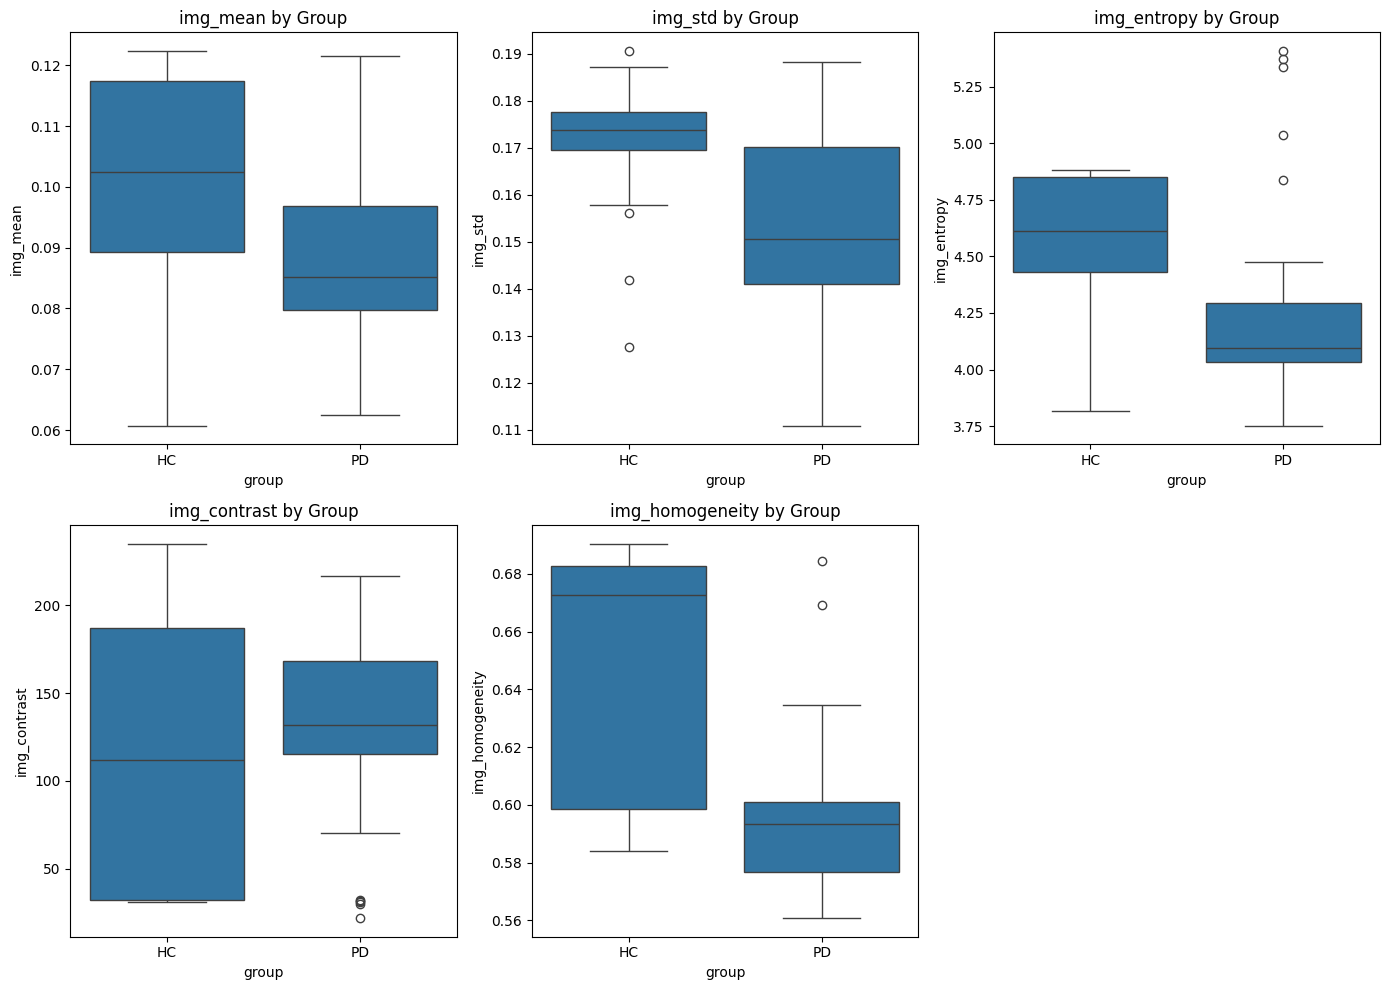

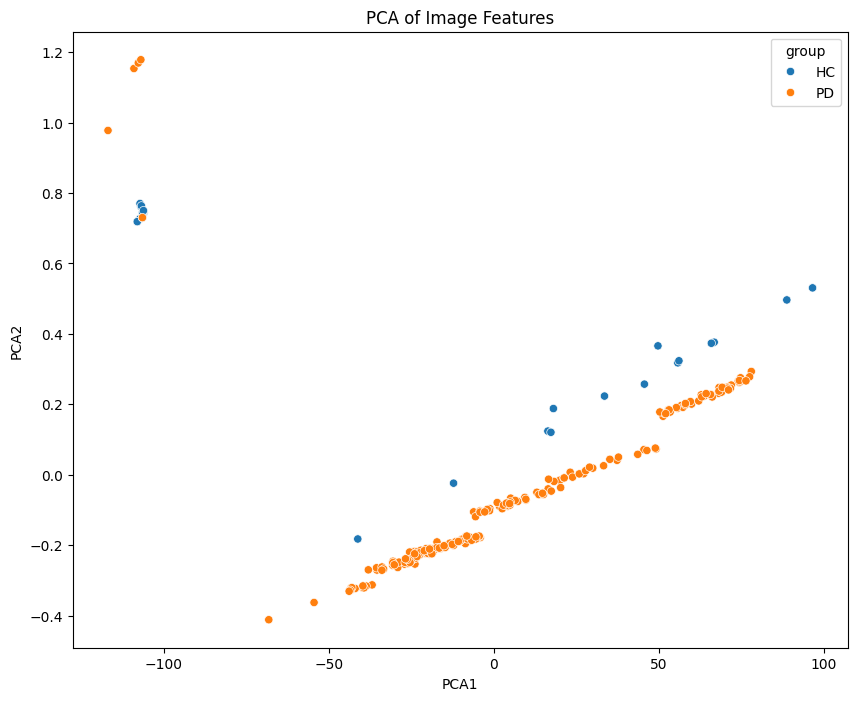

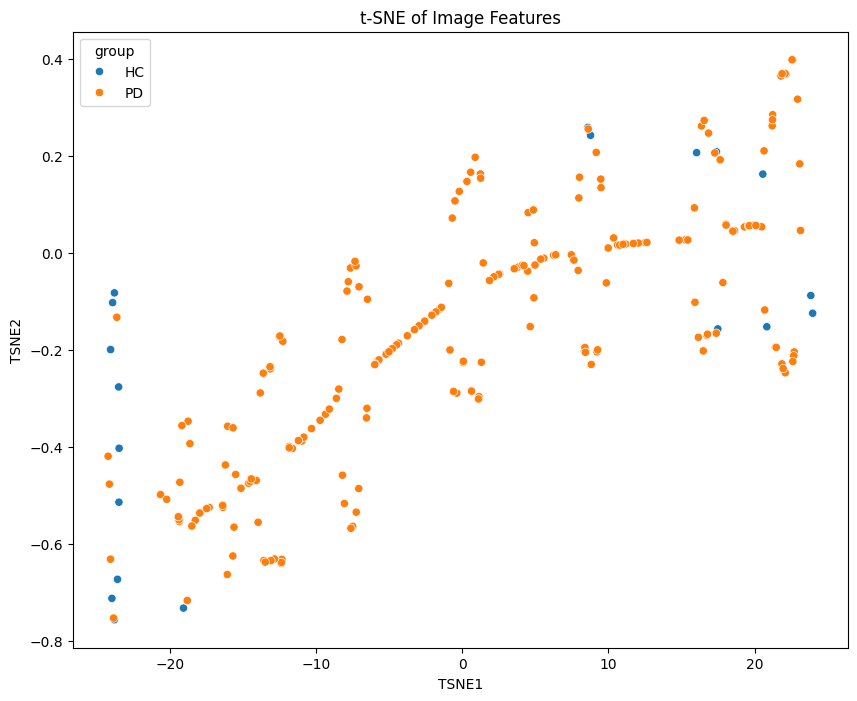

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

def create_visualizations():
    # Load the feature dataframe
    df = pd.read_csv('image_features.csv')
    
    # 1. Feature boxplots - compare HC vs PD
    plt.figure(figsize=(14, 10))
    features = ['img_mean', 'img_std', 'img_entropy', 'img_contrast', 'img_homogeneity']
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='group', y=feature, data=df)
        plt.title(f'{feature} by Group')
    
    plt.tight_layout()
    plt.savefig('feature_comparison.png')
    
    # 2. PCA visualization
    feature_cols = [col for col in df.columns if col.startswith('img_')]
    X = df[feature_cols].fillna(0)  # Handle any NaN values
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    
    pca_df = pd.DataFrame({
        'PCA1': pca_result[:, 0],
        'PCA2': pca_result[:, 1],
        'group': df['group']
    })
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='group', data=pca_df)
    plt.title('PCA of Image Features')
    plt.savefig('pca_visualization.png')
    
    # 3. t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_result[:, 0],
        'TSNE2': tsne_result[:, 1],
        'group': df['group']
    })
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='group', data=tsne_df)
    plt.title('t-SNE of Image Features')
    plt.savefig('tsne_visualization.png')
    
    # Return dataframes for dashboard
    return df, pca_df, tsne_df

def create_dashboard(df, pca_df, tsne_df):
    # Create a Dash application for interactive visualization
    app = dash.Dash(__name__)
    
    app.layout = html.Div([
        html.H1("Brain Imaging Analysis Dashboard"),
        
        html.Div([
            html.H3("Feature Distribution"),
            dcc.Dropdown(
                id='feature-dropdown',
                options=[{'label': col, 'value': col} for col in df.columns if col.startswith('img_')],
                value='img_mean'
            ),
            dcc.Graph(id='feature-histogram')
        ]),
        
        html.Div([
            html.H3("Dimensionality Reduction"),
            dcc.RadioItems(
                id='dr-method',
                options=[
                    {'label': 'PCA', 'value': 'pca'},
                    {'label': 't-SNE', 'value': 'tsne'}
                ],
                value='pca'
            ),
            dcc.Graph(id='dr-plot')
        ])
    ])
    
    @app.callback(
        Output('feature-histogram', 'figure'),
        [Input('feature-dropdown', 'value')]
    )
    def update_histogram(feature):
        fig = px.histogram(df, x=feature, color='group', barmode='overlay',
                          title=f'Distribution of {feature} by Group')
        return fig
    
    @app.callback(
        Output('dr-plot', 'figure'),
        [Input('dr-method', 'value')]
    )
    def update_dr_plot(method):
        if method == 'pca':
            fig = px.scatter(pca_df, x='PCA1', y='PCA2', color='group',
                            title='PCA Visualization')
        else:
            fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='group',
                            title='t-SNE Visualization')
        return fig
    
    # Run the dashboard
    print("Starting dashboard...")
    app.run_server(debug=True)

if __name__ == '__main__':
    df, pca_df, tsne_df = create_visualizations()
    create_dashboard(df, pca_df, tsne_df)

SyntaxError: invalid syntax (686782562.py, line 1)